<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/NEWNEW_MIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')



df = df[df['n/m']==2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] #cple
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [2]:
y_new = []
cnt0=0
cnt1=0
cnt2=0
cnt3=0
for val in y:
  if(val<10):
    y_new.append(0)
    cnt0+=1
  elif(10 <= val and val<1000):
    y_new.append(1)
    cnt1+=1
  else:
    y_new.append(2)
    cnt2+=1

cnt = 0
if(cnt0>0):
  cnt+=1
if(cnt1>0):
  cnt+=1
if(cnt2>0):
  cnt+=1
if(cnt3>0):
  cnt+=1

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)

In [3]:
names = [ 'av.length', 'n', 'std.dev', 'k', 'm', 'max']
X_modified = X.drop([   'n/m', 'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','median', 'min', 'range'], axis = 1)
print(X_modified.head())
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(random_state=0)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)


     n   m   av.length     std.dev  max    k          y
0  120  60  283.708344  103.896957  464  105   5.717196
1  140  70   99.121429   20.696663  148   66   9.256227
2  120  60   55.000000   23.464617   96   57  10.384745
3  160  80   53.724998   29.127333  100   78  29.243601
4  120  60   98.508331   20.886244  158   62   6.302492


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.9)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y', 'k', 'm'], axis = 1)

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y', 'k', 'm'], axis = 1)
X_test = sc.transform(X_test)

1374
153
        n    m   av.length    std.dev  max    k             y
1362  200  100  101.815002  50.574791  271  125  99999.000000
511    80   40   51.612499  29.341934   96   55      5.484429
9      40   20   65.550003  22.500086  100   30      0.920937
393    20   10   75.550003  11.834272   97   16      0.068325
471    80   40   76.237503  15.193471  100   41      2.039949


In [6]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(8, input_dim = X_modified.shape[1]-3, activation='relu'))

classifier.add(Dense(12, activation = 'relu'))
classifier.add(Dropout(0.125))

#classifier.add(Dense(32, activation = 'relu'))

#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(16, activation = 'relu'))

#classifier.add(Dense(16, activation='relu'))

#classifier.add(Dense(8, activation='relu'))

#classifier.add(Dense(12, activation='relu'))

classifier.add(Dense(cnt, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 39        
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 64, 
                    epochs = 350, shuffle = True)

Epoch 1/350
22/22 [==============================] - 1s 6ms/step - loss: 1.1965 - accuracy: 0.2758
Epoch 2/350
22/22 [==============================] - 0s 6ms/step - loss: 1.1163 - accuracy: 0.4039
Epoch 3/350
22/22 [==============================] - 0s 6ms/step - loss: 1.0604 - accuracy: 0.4287
Epoch 4/350
22/22 [==============================] - 0s 4ms/step - loss: 1.0184 - accuracy: 0.4418
Epoch 5/350
22/22 [==============================] - 0s 4ms/step - loss: 0.9815 - accuracy: 0.5167
Epoch 6/350
22/22 [==============================] - 0s 3ms/step - loss: 0.9513 - accuracy: 0.5255
Epoch 7/350
22/22 [==============================] - 0s 3ms/step - loss: 0.9254 - accuracy: 0.5517
Epoch 8/350
22/22 [==============================] - 0s 3ms/step - loss: 0.8968 - accuracy: 0.5524
Epoch 9/350
22/22 [==============================] - 0s 3ms/step - loss: 0.8679 - accuracy: 0.5626
Epoch 10/350
22/22 [==============================] - 0s 3ms/step - loss: 0.8361 - accuracy: 0.6033
Epoch 11/

accuracy: 95.42%


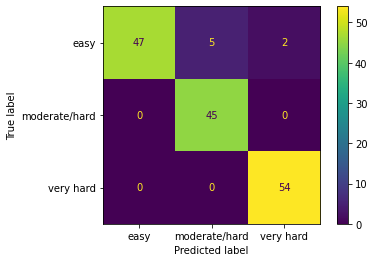

In [8]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])
cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [9]:
column_names = ['n', 'k', 'n/m', 'av.length', 'std.dev', 'y']
df_reg = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': 2, 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)
#VM

153
153


In [10]:
column_names = ['n', 'k', 'm', 'std.dev', 'y']
df_reg0 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

153
153


In [11]:
column_names = ['n', 'k', 'av.length', 'std.dev', 'm', 'y']
df_reg2 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

153
153


In [12]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')




df = df[df['n/m']!=2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] 
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [13]:
y_new = []
for val in y:
  if(val<10):
    y_new.append(0)
  elif(10 <= val and val <1000):
    y_new.append(1)
  else:
    y_new.append(2)

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)
X_modified = X

In [14]:
from imblearn.over_sampling import RandomOverSampler

names =[ 'std.dev', 'n','n/m', 'max','av.length', 'm', 'k']
X_modified = X.drop([  'median', 'range',  'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n'], axis = 1)
X_modified['n/m'] = X_modified['n/m']
#print(X_modified.head())

oversample = RandomOverSampler(random_state=0)
#oversample.fit(X_modified, y_encoded)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [16]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.9)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y',  'm'], axis = 1)
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y',  'm'], axis = 1)
X_test = sc.transform(X_test)

12363
1374
         n   m    n/m   av.length    std.dev  max    k            y
3234    90  10   9.00  100.822220  44.502377  206   68  4164.456055
4495    22   2  11.00   93.363640  21.006907  124   19     1.223762
10982   72  32   2.25   53.569443  31.970419  100   50     4.486688
9657    54  18   3.00  104.722221  21.267759  153   39     5.129042
5976   198  72   2.75  101.570709  46.206142  231  115    49.303917


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(16, input_dim = X_modified.shape[1]-2, activation='relu'))

classifier.add(Dropout(0.2))

classifier.add(Dense(3, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                112       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 32, 
                    epochs = 120)

Epoch 1/120
387/387 [==============================] - 1s 2ms/step - loss: 0.7050 - accuracy: 0.7021
Epoch 2/120
387/387 [==============================] - 1s 2ms/step - loss: 0.4499 - accuracy: 0.8191
Epoch 3/120
387/387 [==============================] - 1s 2ms/step - loss: 0.4080 - accuracy: 0.8368
Epoch 4/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3950 - accuracy: 0.8425
Epoch 5/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3800 - accuracy: 0.8462
Epoch 6/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3686 - accuracy: 0.8537
Epoch 7/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3630 - accuracy: 0.8553
Epoch 8/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3510 - accuracy: 0.8578
Epoch 9/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3445 - accuracy: 0.8607
Epoch 10/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3370 - accura

accuracy: 91.27%


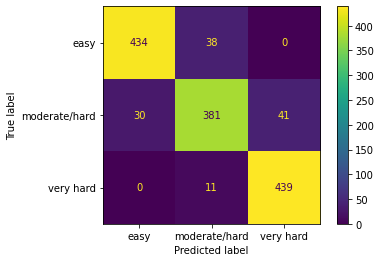

In [19]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])

cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [20]:
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': X_test_copy.iloc[i]['n/m'], 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)

for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

In [21]:
print(df_reg.shape[0])
print(df_reg.head(500))

480
         n      k   n/m   av.length    std.dev           y
0     80.0   55.0  2.00   51.612499  29.341934    5.484429
1    180.0   48.0  2.00   73.844444  14.182301   15.753226
2    160.0   50.0  2.00   74.206253  14.587879   11.280739
3    180.0   72.0  2.00  100.099998  20.167759   20.352310
4    180.0   70.0  2.00   96.583336  19.650255   15.991193
..     ...    ...   ...         ...        ...         ...
475  100.0   83.0  2.50   96.209999  47.907383    2.674106
476  162.0   76.0  2.25   46.740742  28.289444   31.904070
477  140.0   97.0  5.00   99.942856  45.319302  750.447876
478  220.0  126.0  2.75   97.318184  45.401592   56.788799
479  198.0   72.0  3.00   62.722221  23.200050   41.786938

[480 rows x 6 columns]


In [22]:
print(df_reg0.head())

      n     k     m    std.dev         y    max
0  40.0  30.0  20.0  22.500086  0.920937  100.0
1  20.0  16.0  10.0  11.834272  0.068325   97.0
2  80.0  41.0  40.0  15.193471  2.039949  100.0
3  60.0  54.0  30.0  55.121284  2.863895  238.0
4  60.0  41.0  30.0  20.575506  1.899857  139.0


In [23]:
print(df_reg2.head())

       n      k   av.length    std.dev      m        y
0  200.0  125.0  101.815002  50.574791  100.0  99999.0
1   40.0   37.0   87.949997  48.465660   20.0  99999.0
2  120.0   87.0   93.183334  47.574444   60.0  99999.0
3  200.0  119.0  101.699997  49.112724  100.0  99999.0
4  160.0  115.0  103.606247  48.652172   80.0  99999.0


In [24]:
for i in range(df_reg2.shape[0]):
  if(df_reg2.iloc[i]['y'] == 99999):
    df_reg2.loc[i, 'y'] = 4510

for i in range(df_reg.shape[0]):
  if(df_reg.iloc[i]['y'] == 99999):
    df_reg.loc[i, 'y'] = 4510

for i in range(df_reg0.shape[0]):
  if(df_reg0.iloc[i]['y'] == 99999):
    df_reg0.loc[i, 'y'] = 4510

print(df_reg['y'].max())
print(df_reg0['y'].max())
print(df_reg2['y'].max())
shuffled = df_reg.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

yy_final = []
predd_final = []

2043.156128
61.735558
4510.0


In [25]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
print(tmp.head(60))
#y = np.log10(tmp['y']*10)+20
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

2167
2167
    index      n      k    n/m   av.length     std.dev     y
0     124  140.0   74.0   2.00   56.107143   27.614428    21
1     101   40.0   37.0   5.00  161.350006   33.603683    70
2    1391   72.0   56.0   6.00  106.263885   42.463898   148
3    1657  200.0   77.0   5.00  101.000000   20.615650   251
4     899  126.0   96.0   3.00  114.595238   48.629894    70
5    1990  180.0   51.0   5.00   75.150002   14.300245   623
6     566  120.0   67.0   2.00   53.291668   29.580088    18
7    1538  120.0   74.0   5.00   49.958332   28.601999   208
8     645   80.0   56.0   5.00   52.587502   26.850121    33
9     909   90.0   77.0   4.50  104.044441   53.433338    71
10    460  144.0   50.0   2.25   74.284721   14.988883    19
11   1017  110.0   85.0   2.75  111.054543   51.288677    86
12   1789  162.0  113.0   4.50  100.049385   52.371666   360
13   1293  120.0   93.0   5.00   99.625000   48.803493   133
14   2002  126.0  104.0   3.00  309.650787  108.644478   660
15    719  108

In [26]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer="Adam")
    return model

In [27]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.9)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)
print(type(y_train))
for i in range(y_train.shape[0]):
  if(y_train.iloc[i] > 1000):
    y_train.iloc[i] = 1001
print(y_train.max())
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

<class 'pandas.core.series.Series'>
1001
Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


31/31 [==============================] - 1s 2ms/step - loss: 2314196.2500
Epoch 2/300
31/31 [==============================] - 0s 2ms/step - loss: 972522.7500
Epoch 3/300
31/31 [==============================] - 0s 2ms/step - loss: 367659.7812
Epoch 4/300
31/31 [==============================] - 0s 2ms/step - loss: 178087.7812
Epoch 5/300
31/31 [==============================] - 0s 3ms/step - loss: 118101.4219
Epoch 6/300
31/31 [==============================] - 0s 2ms/step - loss: 93542.3281
Epoch 7/300
31/31 [==============================] - 0s 2ms/step - loss: 81201.6484
Epoch 8/300
31/31 [==============================] - 0s 2ms/step - loss: 73580.8984
Epoch 9/300
31/31 [==============================] - 0s 2ms/step - loss: 65471.2656
Epoch 10/300
31/31 [==============================] - 0s 2ms/step - loss: 58744.8008
Epoch 11/300
31/31 [==============================] - 0s 2ms/step - loss: 55507.8672
Epoch 12/300
31/31 [==============================] - 0s 2ms/step - loss: 51477.

In [28]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

4/4 [==============================] - 0s 3ms/step
r_square score:  0.8505481778243398
RMSE:


130.66280095876186

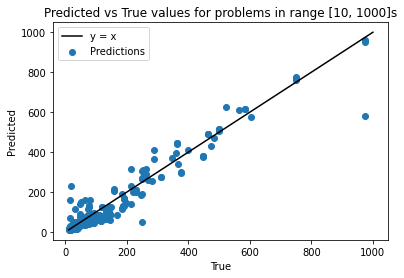

In [29]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  yy_final.append(yy[i])
  predd_final.append(predd[i])
  if(yy[i]>=10 and yy[i]<1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(10, 1000, 2000)
y = x
plt.title('Predicted vs True values for problems in range [10, 1000]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x, y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [30]:
shuffled = df_reg0.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [31]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

5104
5104
        n     k     m    std.dev    max   y
0    72.0  35.0  32.0  14.472221  100.0   7
1    36.0  28.0   8.0  25.803101  100.0   7
2    36.0  31.0  12.0  24.033888  150.0   4
3    54.0  37.0  24.0  20.949141   99.0   3
4    40.0  28.0  10.0  14.801051  100.0   7
5    20.0  20.0   4.0  23.558662   97.0   0
6    20.0  17.0   5.0  15.812304   79.0   0
7    20.0  17.0  10.0  20.396788   98.0   0
8    80.0  71.0  40.0  69.608765  319.0   4
9    20.0  18.0   4.0  15.291121   98.0   2
10   18.0  13.0   4.0  15.927224   71.0   0
11   40.0  27.0  10.0  14.382482  100.0   5
12   20.0  20.0   8.0  39.817310  197.0   0
13   60.0  37.0  24.0  19.931938  134.0   7
14   40.0  31.0  10.0  15.335479  100.0  10
15   60.0  50.0  30.0  52.806171  371.0   0
16   40.0  33.0  16.0  36.477039  159.0   3
17   40.0  32.0  20.0  22.914207  100.0   1
18   36.0  30.0  12.0  30.508223  141.0   4
19   20.0  18.0   5.0  22.233866  154.0   1
20   20.0  16.0   5.0  29.953428   94.0   1
21   54.0  35.0  18.0 

In [32]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 10*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(12, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [33]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.9)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


for i in range(X_train.shape[0]):
  if(y_train.iloc[i] > 10):
    y_train.iloc[i] = 11

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


72/72 [==============================] - 1s 2ms/step - loss: 17.9043
Epoch 2/300
72/72 [==============================] - 0s 2ms/step - loss: 11.3153
Epoch 3/300
72/72 [==============================] - 0s 2ms/step - loss: 7.5413
Epoch 4/300
72/72 [==============================] - 0s 2ms/step - loss: 5.1897
Epoch 5/300
72/72 [==============================] - 0s 2ms/step - loss: 4.0874
Epoch 6/300
72/72 [==============================] - 0s 2ms/step - loss: 3.5955
Epoch 7/300
72/72 [==============================] - 0s 2ms/step - loss: 3.3589
Epoch 8/300
72/72 [==============================] - 0s 2ms/step - loss: 2.9141
Epoch 9/300
72/72 [==============================] - 0s 2ms/step - loss: 2.6110
Epoch 10/300
72/72 [==============================] - 0s 2ms/step - loss: 2.3886
Epoch 11/300
72/72 [==============================] - 0s 2ms/step - loss: 2.2582
Epoch 12/300
72/72 [==============================] - 0s 2ms/step - loss: 2.1425
Epoch 13/300
72/72 [===========================

In [34]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

8/8 [==============================] - 0s 2ms/step
r_square score:  -0.1501931212987666
RMSE:


13.905996466901204

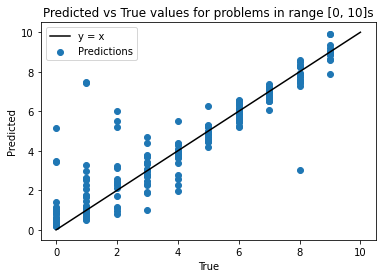

In [35]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  yy_final.append(yy[i])
  predd_final.append(predd[i])
  if(yy[i]<10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(0, 10, 100)
y = x
plt.title('Predicted vs True values for problems in range [0, 10]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [36]:
shuffled = df_reg2.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [37]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

56672
56672
        n      k   av.length     std.dev     m     y
0   176.0  154.0  466.017059  157.078964  64.0  2182
1   200.0  170.0  470.024994  173.267715  40.0  4510
2   126.0  110.0  505.349213  130.707016  14.0  4510
3   120.0  101.0  467.700012  115.940849  60.0  4510
4   160.0   69.0   98.631248   19.575890  16.0  4510
5   140.0  127.0  569.014282  133.063202  28.0  4510
6   140.0  113.0  343.121429  121.472290  35.0  4510
7   100.0   87.0  397.079987  100.062172  20.0  4510
8   126.0  112.0  322.039673  109.737984  21.0  4510
9   180.0  154.0  706.877808  175.294418  90.0  4510
10  200.0  170.0  477.850006  163.834488  50.0  4510
11  180.0  158.0  446.294434  155.220795  30.0  4510
12  198.0   77.0   99.454544   19.191410  22.0  4510
13  144.0  121.0  373.298615  131.739197  48.0  2511
14  140.0  119.0  365.392853  118.369652  35.0  4510
15  140.0   96.0   99.664284   44.100540  14.0  4510
16  100.0   86.0  406.450012  103.975075  10.0  4510
17  160.0  100.0  102.606247   46.

In [38]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(16, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(16, activation = 'relu'))

    model.add(Dense(4, activation = 'relu'))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [39]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.9)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=60, batch_size=128, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


399/399 [==============================] - 1s 2ms/step - loss: 263406.3125
Epoch 2/60
399/399 [==============================] - 1s 2ms/step - loss: 109907.5938
Epoch 3/60
399/399 [==============================] - 1s 2ms/step - loss: 87642.0156
Epoch 4/60
399/399 [==============================] - 1s 2ms/step - loss: 75523.3594
Epoch 5/60
399/399 [==============================] - 1s 2ms/step - loss: 65929.5078
Epoch 6/60
399/399 [==============================] - 1s 2ms/step - loss: 57288.1445
Epoch 7/60
399/399 [==============================] - 1s 2ms/step - loss: 48574.2383
Epoch 8/60
399/399 [==============================] - 1s 2ms/step - loss: 43543.6953
Epoch 9/60
399/399 [==============================] - 1s 2ms/step - loss: 40042.5781
Epoch 10/60
399/399 [==============================] - 1s 2ms/step - loss: 37580.3867
Epoch 11/60
399/399 [==============================] - 1s 2ms/step - loss: 38071.2031
Epoch 12/60
399/399 [==============================] - 1s 2ms/step - los

In [40]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

45/45 [==============================] - 0s 1ms/step
r_square score:  0.9843675533806326
RMSE:


146.41199070542666

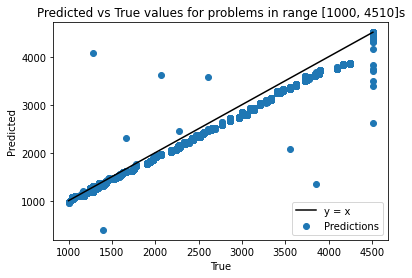

In [41]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  yy_final.append(yy[i])
  predd_final.append(predd[i])
  if(yy[i]>1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(1000, 4510, 2000)
y = x

plt.title('Predicted vs True values for problems in range [1000, 4510]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [42]:
print("r_square score: ", r2_score(yy_final, predd_final))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(yy_final)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(predd_final)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

r_square score:  0.9870296378915828
RMSE:


139.9686844202252

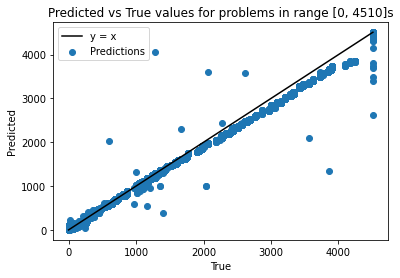

In [43]:
x = np.linspace(0, 4510, 2000)
y = x

plt.title('Predicted vs True values for problems in range [0, 4510]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_final, predd_final)
plt.legend(['y = x', 'Predictions'])